# Predicting a generic sinusoidal waveform

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [51]:
# np.random.seed(1337)  # for reproducibility

# Simulate data
cycle = 20
step = 0.05
noise = 0.00 # standard deviation from 0
decaying_coef = 0.00
start_coef = 1
stop_coef = 3
step_coef = 0.2

data = []

for coeff in np.arange(start_coef, stop_coef, step_coef):
    end_pt = 2 * np.pi * cycle
    t = np.arange(0, end_pt, step)
    a = np.sin(coeff * t)
    a_noisy = a + np.random.normal(0, noise, a.size)
    a_decaying = a_noisy * np.exp(-decaying_coef * t)
    data.append(a_decaying)

print("Number of generic samples:", len(data))
# Note: If noise is not modulated by the exponential function, it will overwhelm the signal near the end of the data sequence
# which is where test data is picked from. We can modulate it in simulated environment but in experiments, we may have to discard
# data near the end of the motion.

Number of generic samples: 10


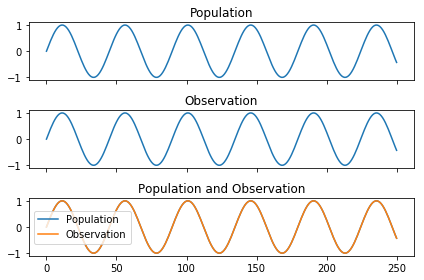

In [52]:
# visualize data
n_plot = int(a.size / 10)

_, axarr = plt.subplots(3, sharex=True, sharey=True)
axarr[0].plot(a[:n_plot])
axarr[0].set_title('Population')
axarr[1].plot(a_decaying[:n_plot])
axarr[1].set_title('Observation')
axarr[2].plot(a[:n_plot], label="Population")
axarr[2].plot(a_decaying[:n_plot], label="Observation")
axarr[2].set_title('Population and Observation')
axarr[2].legend()
plt.tight_layout()
plt.show()

In [66]:
# hyperparameters
DATA_DIM = 1
N_PREV = 100 # number of previous steps used to predict the next step

In [67]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for series in data:
        for j in range(len(series)-n_prev):
            docX.append(series[j:j+n_prev])
            docY.append(series[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data):  
    """
    This just splits data to training and testing parts
    """
    test_id = np.random.randint(0, len(data))
    data_train = data[:test_id] + data[test_id+1:]
    np.random.shuffle(data_train)
    X_train, y_train = _load_data(data_train, is_shuffled=True)
    X_test, y_test = _load_data([data[test_id]], is_shuffled=False)
    
    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data)

In [68]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=True), input_shape=(None, 1)))
model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
# model.add(Dense(units=10, activation="linear"))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [69]:
#n_prev=50, units=10, epochs=50: decent accuracy half the waveform

In [70]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_split=0.2)

Train on 17380 samples, validate on 4346 samples
Epoch 1/40
17380/17380 [==============================] - 14s 831us/step - loss: 0.0685 - val_loss: 0.0033
Epoch 2/40
17380/17380 [==============================] - 14s 781us/step - loss: 0.0014 - val_loss: 5.8217e-04
Epoch 3/40
17380/17380 [==============================] - 12s 708us/step - loss: 3.3957e-04 - val_loss: 1.5675e-04
Epoch 4/40
17380/17380 [==============================] - 11s 644us/step - loss: 1.3249e-04 - val_loss: 1.2316e-04
Epoch 5/40
17380/17380 [==============================] - 11s 642us/step - loss: 9.0895e-05 - val_loss: 6.2126e-05
Epoch 6/40
17380/17380 [==============================] - 11s 643us/step - loss: 6.0069e-05 - val_loss: 4.2821e-05
Epoch 7/40
17380/17380 [==============================] - 17s 998us/step - loss: 4.7390e-05 - val_loss: 4.4589e-05
Epoch 8/40
17380/17380 [==============================] - 25s 1ms/step - loss: 3.6244e-05 - val_loss: 2.5985e-05
Epoch 9/40
17380/17380 [=====================

dict_keys(['val_loss', 'loss'])
40


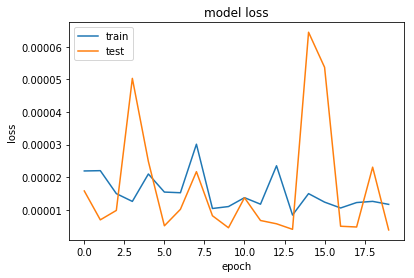

In [71]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-20:])
plt.plot(history.history['val_loss'][-20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
# evaluate model fit
score = model.evaluate(X_test, y_test)
print('Test score:', score)

2414/2414 [==============================] - 1s 462us/step
Test score: 3.72351626349015e-06


In [73]:
# perform approximation
test_prediction = model.predict(X_test)

In [74]:
# perform modelling
X_model = X_test[0]
modelled_data = []
dims = 1, X_model.shape[0], X_model.shape[1]
for i in range(len(y_test)):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step)
# evaluate
if len(modelled_data)==len(y_test):
    print(np.mean((modelled_data-y_test)**2))

0.9891627489496678


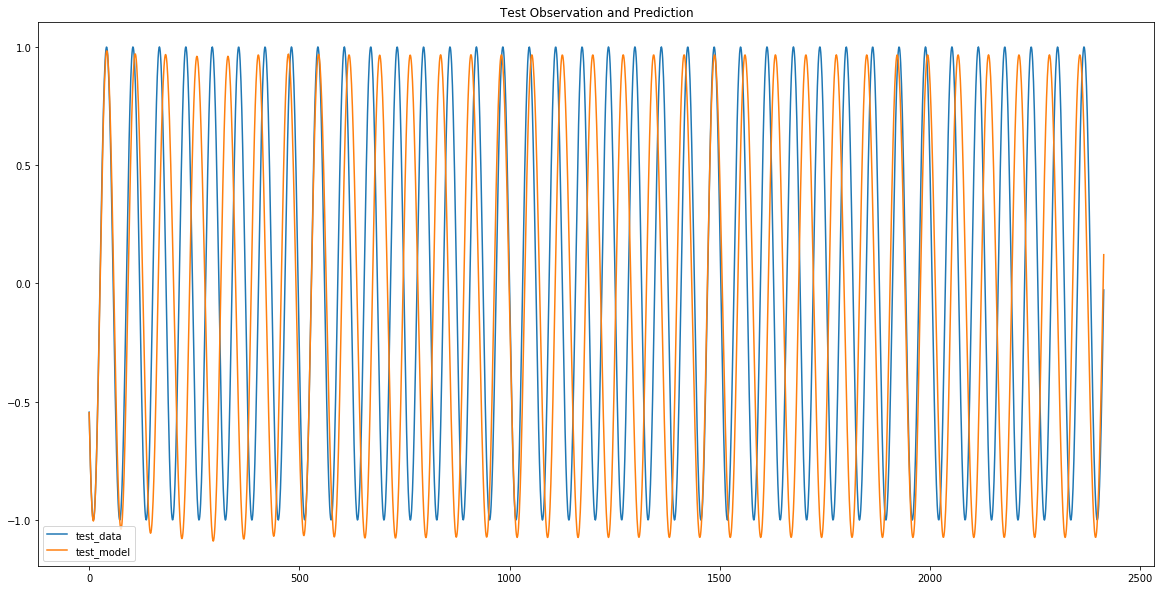

In [75]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(modelled_data[:], label='test_model')
plt.title('Test Observation and Prediction')
plt.legend()

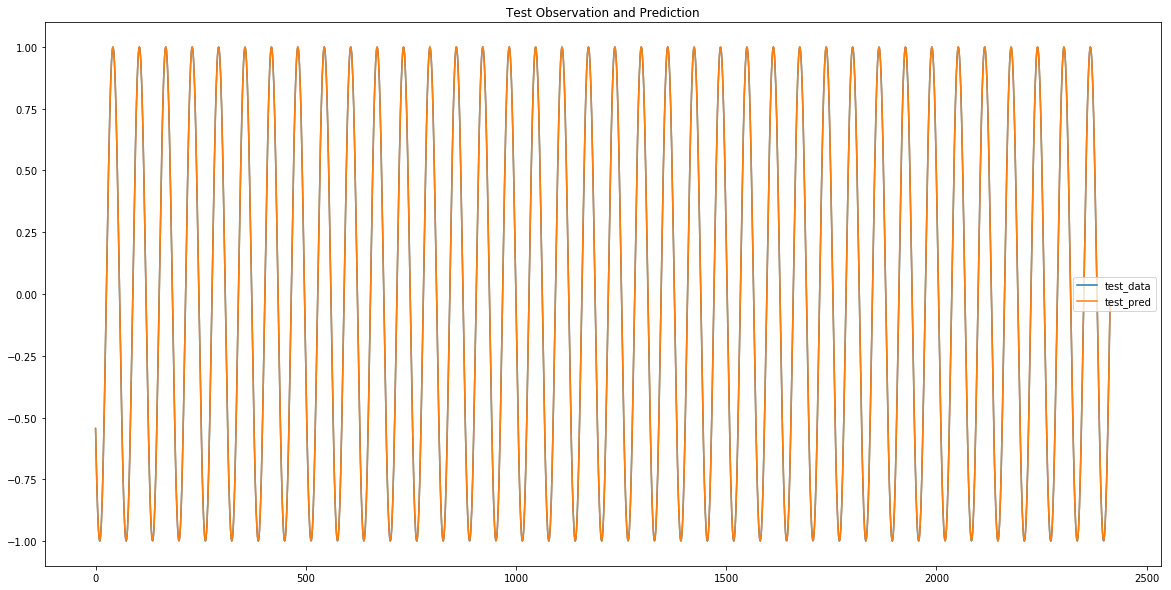

In [76]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

In [77]:
train_prediction = model.predict(X_train)

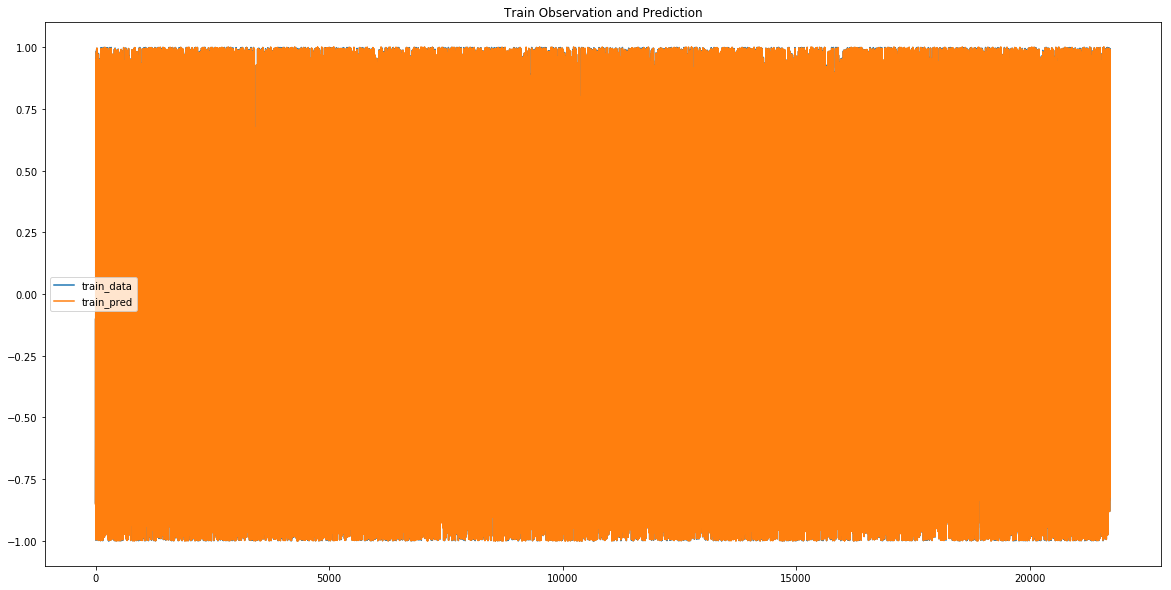

In [78]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()